# Import Statements
We will use several libraries for numerical computations and plotting in this notebook.  Run the next code cell to import all necessary libraries **before** proceeding to any subsequent lines of code!

In [1]:
import numpy as np
from numpy import linalg as la
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12

# Overview
In this notebook we will consider vibrational strong coupling between a cavity and the HF molecule where the cavity
is tuned to the fundamental transition of HF within the Harmonic Oscillator approximation.  

We will deploy two different Hamiltonians: The minimal coupling Hamiltonian ( "p dot A"), and the "d dot E" Hamiltonian from Eq. (2.50) and Eq. (2.51) of Chapter 2.

The form of these coupled Hamiltonians are
\begin{equation}
\mathcal{H}_{\rm p \cdot A} = \mathcal{H}_{\rm m} \otimes \mathcal{I}_{\rm P} + \mathcal{I}_{\rm M} \otimes \mathcal{H}_{\rm c} + \mathcal{I}_{\rm M} \otimes \mathcal{H}_{\rm dia} + \mathcal{H}_{\rm int},
\end{equation}
for the minimal coupling Hamiltonian, and 
\begin{equation}
\mathcal{H}_{\rm PF} = \mathcal{H}_{\rm m} \otimes \mathcal{I}_{\rm P} + \mathcal{I}_{\rm M} \otimes \mathcal{H}_{\rm c} + \mathcal{H}_{\rm dse} \otimes \mathcal{I}_{\rm P}  + \mathcal{H}_{\rm int},
\end{equation}
for the Pauli-Fierz Hamiltonian. 

The operator forms of the bare matter term is given in Eq. 2.14, the bare cavity term in Eq. 2.18, the interaction and diamagnetic terms for the "p dot A" Hamiltonian are given in Eq. 2.25, and the interaction and dipole self energy terms for the Pauli-Fierz Hamiltonian are given in Eq. 2.43.  Each term can be expressed in terms of the 
raising and lowering operators for either the matter, photon, or (for the interaction terms) both subsystems.  So, a key first step for building the matrix representations of the Hamiltonians will be to build matrix representations of the ladder operators for each subsystem.  We will define a function `build_ladder_operator_matrix(dimension)` that will do just this; because the ladder operators for the matter subsystem within the Harmonic oscillator approximation obey the same rules as the ladder operators for the photonic subsystem, we can use the same function for both subsystems, we will just store the matrices in different variables to keep track of them in the execution of our code.

The next code block will define this function and illustrate its use for several different truncations of the dimension of the basis.  This function will be called upon later in this notebook when we start building terms in the Hamiltonian matrices.




In [2]:
def build_ladder_operator_matrices(dimension):
    """
    Builds the matrix representation of the bosonic raising and lowering operators to be used 
    for the matter subsystem within the Harmonic oscillator approximation and the photonic subsystem
    
    Arguments
    ---------
    
    dimension : The dimension of the truncated Hilbert space.
    
    Returns
    -------
    raise_mat : the raising operator as a NumPy array
    
    lower_mat : the lowering operator as a NumPy array
    
    Example
    --------
    a_dag, a = build_ladder_operator_matrices(3)
    
    >>> a  
    >>>       [[0.         1.         0.        ]
              [0.         0.         1.41421356]
              [0.         0.         0.        ]]
    
    >>> a_dag
    >>>       [[0.         0.         0.        ]
               [1.         0.         0.        ]
               [0.         1.41421356 0.        ]]
    
    """
    lower_mat = np.zeros((dimension, dimension))
    
    for i in range(dimension - 1):
        lower_mat[i, i + 1] = np.sqrt(i + 1)
        
    raise_mat = lower_mat.conj().T
    
    return raise_mat, lower_mat


In [3]:
# build ladder operator when matter Hilbert space is truncated to include 4 states
a_dag, a = build_ladder_operator_matrices(4)

# print raising operator
print("The raising operator matrix for the matter Hilbert space truncated to include 4 states")
print(a_dag)

# print lowering opreator
print("The lowering operator matrix for the matter Hilbert space truncated to include 4 states")
print(a)

# build ladder operator when matter Hilbert space is truncated to include 4 states
b_dag, b = build_ladder_operator_matrices(2)

# print raising operator
print("The raising operator matrix for the photonic Hilbert space truncated to include 2 states")
print(b_dag)

# print lowering opreator
print("The lowering operator matrix for the photonic Hilbert space truncated to include 2 states")
print(b)

The raising operator matrix for the matter Hilbert space truncated to include 4 states
[[0.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.         1.41421356 0.         0.        ]
 [0.         0.         1.73205081 0.        ]]
The lowering operator matrix for the matter Hilbert space truncated to include 4 states
[[0.         1.         0.         0.        ]
 [0.         0.         1.41421356 0.        ]
 [0.         0.         0.         1.73205081]
 [0.         0.         0.         0.        ]]
The raising operator matrix for the photonic Hilbert space truncated to include 2 states
[[0. 0.]
 [1. 0.]]
The lowering operator matrix for the photonic Hilbert space truncated to include 2 states
[[0. 1.]
 [0. 0.]]


# Details of the Matter Subsystem within the Harmonic Approximation
We will model the matter subsystem as the vibrational structure of the hydrogen fluoride molecule (HF) within the Harmonic approximation.  Here we discuss the relevant parameters that will enter into the bare matter Hamiltonian terms and the coupling terms in both Hamiltonians.

In the coupled Hamiltonians, $z$ is the effective charge of the HF molecule, $\mu$ is the reduced mass of the HF molecule,
\begin{equation}
\mu = \frac{m_F \cdot m_H}{m_F + m_H}
\end{equation}
and we will define the potential $V(x)$ to be the Harmonic potential of HF as,
\begin{equation}
V(x) = \frac{1}{2} k x^2.
\end{equation}

# Unit system
We will work in atomic units.  In atomic units, so the mass of H and F, the Harmonic force constant, the cavity frequency, the charge
associated with the dipole operator, and the vector potential must all be expressed in atomic units.  We will consider an arbitrary range of values for the vector potential, but all other values will be fixed as follows:

| Quantity    | Value in Atomic Units |
| -------- | ------- |
| mass of F  | 34616.6811    |
| mass of H  | 1837.4731    |
| Force Constant  of HF* |  0.6377 |
| Equilibrium bondlength* | 1.7310 |
| Charge*   | -0.4688 |
| Cavity frequency* | 0.01911


The force constant, charge, and cavity frequency are all quantities that we have derived from some calculations.  
We estimated the force constant using quantum chemistry calculations, specifically using numerical derivatives of CCSD(T)/cc-pVTZ 
energies about the equilibrium geometry located by a geometry optimization at the same level.  Similarly, we computed the RHF/cc-pVTZ dipole moment at this optimized geometry and derived the effective charge as the dipole moment divided by the equilibrium bond length.  The
cavity frequency is matched to the fundamental frequency of HF, which is derived from the Harmonic approximation as follows:
\begin{equation}
\omega_{\rm cav} = \omega_{\rm f} = \sqrt{ \frac{k}{\mu} }
\end{equation}
where $k$ is the force constant and $\mu$ is the reduced mass and $\omega_{\rm f}$ indicates the fundamental frequency of the HF molecule.

In the block below, we will assign or compute these parameters, and we will also plot the vibrational 
energy levels and the potential of the HF molecule in atomic units.

 Cavity Frequency in Atomic Units is 0.019117411406998054


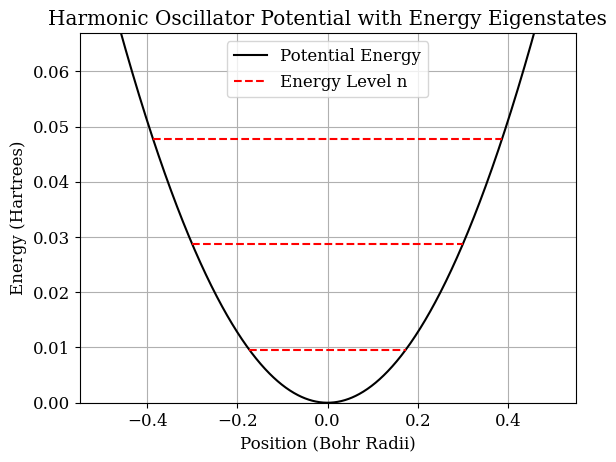

In [4]:



# Force constant of HF in atomic units as computed using centered finite differences at the CCSD(T)/cc-pVTZ level 
# about an equilibrium bondlength of 1.73106 atomic units (0.9160 Angstroms )
k_au = 0.6377016832933821

# reduced mass of HF
mF_au = 34616.6811
mH_au = 1837.4731

mu_au = mF_au * mH_au / (mF_au + mH_au)

# fundamental frequency of HF in atomic units
omega_au = np.sqrt( k_au / mu_au )

# set cavity frequency equal to fundamental
omega_cav  = omega_au

# set charge
z_au = -0.4688

print(F' Cavity Frequency in Atomic Units is {omega_cav}')

hbar = 1.0  # reduced Planck's constant (arbitrary units)

def potential(omega, mu, x):
    """
    Function to plot the Harmonic oscillator potential
    
    Arguments
    ---------
    omega : float
         the fundamental frequency
         
    mu : float
         the reduced mass
         
    x : float or array of floats
         the displacements
         
    Returns
    -------
    V_x : float or array of floats
         the potential along the displacemnts
    """
    
    V_x = 0.5 * mu * omega ** 2 * x ** 2
    
    return V_x


def energy(omega, n):
    """
    Function to compute the energy eigenvalue of the Harmonic oscillator in atomic units
    
    Arguments
    ---------
    omega : float
         the fundamental frequency
         
    n : int
         the quantum number
         
    Returns
    -------
    E_n : float 
        the energy eigenvalue of quantum state n
    """
    hbar = 1 # in atomic units
    
    E_n = hbar * omega * (n + 1/2)
    return E_n

def turning_points(omega, mu, E_n):
    """
    Function to compute the turning points on the potential for state with energy E_n
    
    Arguments
    ---------
    omega : float
         the fundamental frequency
         
    mu : float
         the reduced mass
         
    E_n : float
         the energy eigenvalue of state n
         
    Returns
    -------
    _x_max, x_max : floats 
        positive and negative turning points of state n
    """
    x_max = np.sqrt(2 * E_n / (mu * omega**2))
    return -x_max, x_max

# Define range for x
x = np.linspace(-0.5, 0.5, 1000)
V = potential(omega_au, mu_au, x)

# Plot the potential
plt.plot(x, V, label='Potential Energy', color='black')

# Plot the energy eigenstates
n_max = 3  # number of eigenstates to plot
for n in range(n_max):
    E_n = energy(omega_au, n)
    x_min, x_max = turning_points(omega_au, mu_au, E_n)
    plt.hlines(E_n, x_min, x_max, color='red', linestyle='--', label=f'Energy Level n' if n==0 else None)

# Add labels and legend
plt.title('Harmonic Oscillator Potential with Energy Eigenstates')
plt.xlabel('Position (Bohr Radii)')
plt.ylabel('Energy (Hartrees)')
plt.ylim(0, energy(omega_au, n_max))
plt.legend()
plt.grid()

# Show the plot
plt.show()



With these basic parameters having been computed or assigned, we will write functions that compute matrix
representations of each term in the two Hamiltonians we are considering.  These functions will all have a common structure that 
they will take arguments that specify the dimension of the matter or/and photonic subspaces, and include all relevant parameters ($\omega_f$, $\omega_c$, $E_0$, etc) to complete the matrix.  Each function will call on the `build_ladder_operator_matrices` function build the matrix representation of the relevant ladder operators.

The function `compute_matter_energy_matrix()` will compute the matrix representation of the bare matter Hamiltonian:

\begin{equation}
\mathcal{H}_{\rm m} = \hbar \omega_f \left(\mathcal{A}^{\dagger} \mathcal{A} + \frac{1}{2} \mathcal{I} \right)
\end{equation}
where we use $\mathcal{A}^{\dagger}$ and $\mathcal{A}$ to denote the matrix representation of the ladder operators in the matter Hilbert subspace and $\mathcal{I}$ is the identity matrix in this subspace.

In [5]:
def compute_matter_energy_matrix(matter_dim, k, mu):
    """ 
    Builds the matrix representation of the matter energy operator.

    Arguments
    ---------
    matter_dim : int
      the dimension of the matter basis

    k : float
      force constant

    mu : float
      reduced mass

    Returns
    -------
    matter_Hamiltonian : the matter Hamiltonian as a NumPy array

    Example
    -------
    >>> compute_matter_energy_matrix(2, 1, 1)
    >>> array([[0.5, 0.0],
            [0.0, 1.5]])
    """
    # build raising and lowering operators for the matter subspace using the build_ladder_operator_matrices() function
    a_dag, a = build_ladder_operator_matrices(matter_dim)

    # compute the fundamental frequency
    omega_f = np.sqrt(k / mu)

    # compute the matter Hamiltonian = omega * ( a^dagger a + 1/2 I)
    matter_Hamiltonian = omega_f * ( np.dot(a_dag, a) + np.eye(matter_dim) / 2 )

    # return Matter Hamiltonian
    return matter_Hamiltonian

The function `compute_cavity_energy_matrix()` will compute the matrix representation of the bare cavity Hamiltonian:

\begin{equation}
\mathcal{H}_{\rm c} = \hbar \omega_c \left(\mathcal{B}^{\dagger} \mathcal{B} + \frac{1}{2} \mathcal{I} \right)
\end{equation}
where we use $\mathcal{B}^{\dagger}$ and $\mathcal{B}$ to denote the matrix representation of the ladder operators in the photonic Hilbert subspace and $\mathcal{I}$ is the identity matrix in this subspace.

In [6]:
def compute_cavity_energy_matrix(cavity_dim, omega_cav):
    """ 
    Builds the matrix representation of the matter energy operator.

    Arguments
    ---------
    cavity_dim : int
      the dimension of the photon basis

    omega_cav : float
      the cavity frequency

    Returns
    -------
    cavity_Hamiltonian : the cavity Hamiltonian as a NumPy array

    Example
    -------
    >>> compute_cavity_energy_matrix(2, 1)
    >>> array([[0.5, 0.0],
            [0.0, 1.5]])
    """
    # build raising and lowering operators for the cavity subspace using the build_ladder_operator_matrices() function
    b_dag, b = build_ladder_operator_matrices(cavity_dim)


    # compute the cavity Hamiltonian = omega_cav * ( b^dagger b + 1/2 I)
    cavity_Hamiltonian = omega_cav * ( np.dot(b_dag, b) + 0 * np.eye(matter_dim) / 2 )

    # return Matter Hamiltonian
    return cavity_Hamiltonian

The function `compute_diamagnetic_matrix_p_dot_A()` will compute the matrix representation of the diamagnetic Hamiltonian:

\begin{equation}
\mathcal{H}_{\rm dia} = \frac{z^2}{2 \mu} {\bf A}_0^2\left(\mathcal{B}^{\dagger} + \mathcal{B} \right)^2
\end{equation}
where we $z$ denotes the charge of the matter subsystem, $\mu$ is the reduced mass of the matter subsystem, and ${\bf A}_0$ is the magnitude of the vector potential.

This function is unique to the "p dot A" Hamiltonian.

In [7]:
def compute_diamagnetic_matrix_p_dot_A(cavity_dim, z_charge, A0, mu):
    """ Computes the matrix representation of the diamagnetic Hamiltonian for the p dot A Hamiltonian in the photonic basis
    
    Arguments
    ---------

    cavity_dim : int
      the dimension of the photon basis

    z_charge : float
        the effective charge of the matter subsystem

    A0 : float
        the magnitude of the vector potential of the photonic subsystem

    mu : float
        the reduced mass of the matter subsystem

    Returns
    -------

    diamag_Hamiltonian : numpy array
        Diamagnetic matrix

    Example
    ------- 
    >>> compute_diamagnetic_matrix_p_dot_A(3, 1, 1, 1)
    >>> array([[0.5        0.         0.70710678]
               [0.         1.5        0.        ]
               [0.70710678 0.         1.        ]])
    """
    # build raising and lowering operators for the cavity subspace using the build_ladder_operator_matrices() function
    b_dag, b = build_ladder_operator_matrices(cavity_dim)

    # compute pre-factor z^2/(2 mu) A_0^2
    fac = z_charge ** 2 / (2 * mu) * A0 ** 2

    # take sum of b_dag and b matrices
    b_sum = b_dag + b

    # take product of b_sum
    b_sum_squared = np.dot(b_sum, b_sum)

    # compute diamagnetic Hamiltonian
    diamag_Hamiltonian = fac * b_sum_squared

    return diamag_Hamiltonian

The function `compute_interaction_matrix_p_dot_A()` will compute the matrix representation of the interaction Hamiltonian:

\begin{equation}
\mathcal{H}_{\rm int} = -i\frac{z}{\mu} \sqrt{\frac{\mu \hbar \omega_f}{2} } {\bf A}_0 \left(\mathcal{A}^{\dagger} - \mathcal{A} \right) \otimes \left(\mathcal{B}^{\dagger} + \mathcal{B} \right).
\end{equation}

This function is unique to the "p dot A" Hamiltonian.

In [8]:
def compute_interaction_matrix_p_dot_A(matter_dim, cavity_dim, mu, k, z_charge, A0):
    """  Builds the matrix representation of the interaction operator in the tensor product basis for the p dot A Hamiltonian

    Arguments
    ---------
    matter_dim : int
      the dimension of the matter basis

    cavity_dim : int
      the dimension of the photon basis

    z_charge : float
        the effective charge of the matter subsystem

    A0 : float
        the magnitude of the vector potential of the photonic subsystem

    k : float
        the force constant of the matter subsystem

    mu : float
        the reduced mass of the matter subsystem

    Returns
    -------

    interaction_Hamiltonian : numpy array
        Interaction matrix

    Example
    -------
    >>> compute_interaction_matrix_p_dot_A(2, 2, 1, 1, 1, 0.1)
    >>> array([[0.+0.j         0.+0.j         0.+0.j         0.+0.07071068j]
               [0.+0.j         0.+0.j         0.+0.07071068j 0.+0.j        ]
               [0.+0.j         0.-0.07071068j 0.+0.j         0.+0.j        ]
               [0.-0.07071068j 0.+0.j         0.+0.j         0.+0.j        ]])
    """
    # compute the matter ladder operators
    a_dag, a = build_ladder_operator_matrices(matter_dim)

    # compute the cavity ladder operators
    b_dag, b = build_ladder_operator_matrices(cavity_dim)

    # compute the difference between the matter ladder operators
    a_diff = a_dag - a

    # compute the sum of the cavity ladder operators
    b_sum = b_dag + b

    # compute fundamental frequency
    omega_f = np.sqrt(k / mu)

    # compute the prefactor for the Hamiltonian matrix
    fac = -1j * z_charge / mu * np.sqrt(mu * omega_f / 2) * A0

    # take the Kronecker product of a_diff and b_sum and multiply it by the prefactor
    interaction_Hamiltonian = fac * np.kron(a_diff, b_sum)

    return interaction_Hamiltonian

The remaining two functions are particular to the Paul-Fierz Hamiltonian. 
The function `compute_interaction_matrix_PF()` will compute the matrix representation of the interaction Hamiltonian:
\begin{equation}
\mathcal{H}_{int} = - z \frac{\hbar}{2} \sqrt{\frac{\omega_{cav}}{\mu \omega_f}} {\bf E}_0 \left(\mathcal{A}^{\dagger} + \mathcal{A} \right) \otimes \left(\mathcal{B}^{\dagger} + \mathcal{B} \right)
\end{equation}



In [9]:
def compute_interaction_matrix_PF(matter_dim, cavity_dim, omega_cav, mu, k, z_charge, A0):
    """
    Arguments
    ---------
    matter_dim : int
      the dimension of the matter basis

    cavity_dim : int
      the dimension of the photon basis

    omega_cav : float
        cavity frequency

    z_charge : float
        the effective charge of the matter subsystem

    A0 : float
        the magnitude of the vector potential of the photonic subsystem

    k : float
        the force constant of the matter subsystem

    mu : float
        the reduced mass of the matter subsystem

    Returns
    -------

    interaction_matrix : numpy array
        Interaction matrix
    """
    # compute the fundamental frequency for the matter subsystem
    omega_f = np.sqrt( k / mu)

    # compute the electric field mangitude from the vector potential magnitude
    E0 = np.sqrt( 2 * omega_cav ) * A0

    # compute the prefactor for the Hamiltonian matrix
    fac = - z_charge / 2 * np.sqrt(omega_cav / (mu * omega_f)) * E0

    # build raising and lowering operators for the matter subsystem
    a_dag, a = build_ladder_operator_matrices(matter_dim)

    # build raising and lowering operators for the cavity subsystem
    b_dag, b = build_ladder_operator_matrices(cavity_dim)

    # build the sum of the ladder operators for the matter subsystem
    a_sum = a_dag + a

    # build the sum of the ladder operators for the cavity subsystem
    b_sum = b_dag + b

    # compute the interaction Hamiltonian in the tensor product basis
    interaction_Hamiltonian = fac * np.kron(a_sum, b_sum)

    return interaction_Hamiltonian

The function `compute_dipole_self_energy_matrix_PF()` will compute the matrix representation of the dipole self energy
\begin{equation}
\mathcal{H}_{int} = z^2\frac{\hbar}{4\mu \omega} {\bf E}_0^2 \left(\mathcal{A}^{\dagger} + \mathcal{A} \right)^2
\end{equation}

In [10]:
def compute_dipole_self_energy_PF(matter_dim, omega_cav, mu, k, z_charge, A0):
    """ Compute the matrix representation of the dipole self energy operator in the matter basis

    Arguments
    ---------
    matter_dim : int
        the dimension of the truncated matter Hilbert

    omega_cav : float
        cavity frequency
      
    mu : float
        reduced mass

    k : float
        force constant

    z_charge : float
        the effective charge of the matter subsystem

    A0 : float
        the magnitude of the vector potential of the photonic subsystem

    Returns
    -------
    dipole_self_energy_matrix : numpy array
        Dipole self energy matrix

    Example
    -------
    >>> compute_dipole_self_energy_PF(2, 1, 1, 1, 1, 0.1)
    >>> array([[0.005 0.   ]
               [0.    0.005]])

    """

    # compute the fundamental frequency for the matter subsystem
    omega_f = np.sqrt( k / mu)

    # compute the electric field mangitude from the vector potential magnitude
    E0 = np.sqrt( 2 * omega_cav ) * A0

    # factor z^2\frac{\hbar}{4\mu \omega} {\bf E}_0^2 
    fac = z_charge ** 2 / (4 * mu * omega_f) * E0 ** 2

    # create matter ladder operators
    a_dag, a = build_ladder_operator_matrices(matter_dim)

    # compute the sum of a_dag and a
    a_sum = a_dag + a

    # compute the dipole self energy matrix
    dipole_self_energy_matrix = fac * np.dot(a_sum, a_sum)

    return dipole_self_energy_matrix



We will now build the entire "p dot A" and Pauli-Fierz Hamiltonians in a tensor product basis and find their eigenvalues and ensure they agree.  We will also plot the first few eigenvalues of the Pauli-Fierz Hamiltonian on top of the matter vibrational states to show how the polariton states split from the first excited state energy of the bare matter subsystem.  We will repeat these builds in a minimal basis in a subsequent code block with print statements for each sub-matrix so that interested readers can inspect the form of each matrix in the uncoupled and tensor product bases.

The size of the uncoupled photonic basis can be changed by changing the variable `photon_dim` and the size of the uncoupled matter basis can be changed by changing the variable `matter_dim`.  We also encourage the reader to explore how the eigenvalues converge with increasing basis set size for different magnitudes of the vector potential (here set by the variable `A0_val`).  The other material parameters have been set in an earlier code block in the variables `k_au`, `mu_au`, and `z_val`.

In [11]:
# define dimensions of each subspace
photon_dim = 2 # can make this as small as 2 or as large as you dare... 100 is pretty large and will be slow
matter_dim = 2 # can make this as small as 2 or as large as you dare... 100 is pretty large and will be slow

# compute identity matrix on the matter subspace
I_matter = np.eye(matter_dim)

# compute identity matrix on the photon subspace
I_photon = np.eye(photon_dim)

# set the photon frequency to be equal to the fundamental frequency of HF in atomic units
omega_p_au = np.sqrt( k_au / mu_au)

# assign a magnitude of the vector potential in atomic units
A0_au = 2.0

# compute matter Hamiltonian in the matter basis
H_matter = compute_matter_energy_matrix(matter_dim, k_au, mu_au)

# compute matter Hamiltonian in the tensor product basis
H_matter_tp = np.kron(H_matter, I_photon)

# compute photon Hamiltonian in the photon basis
H_photon = compute_cavity_energy_matrix(photon_dim, omega_p_au)

# compute photon Hamiltonian in the tensor product basis
H_photon_tp = np.kron(I_matter, H_photon)

# compute diamagnetic Hamiltonian in the photon basis
H_diamag = compute_diamagnetic_matrix_p_dot_A(photon_dim, z_au, A0_au, mu_au)


# compute diamagnetic Hamiltonian in the tensor product basis
H_diamag_tp = np.kron(I_matter, H_diamag)

# compute the interaction Hamiltonian for p dot A
H_interaction_pda = compute_interaction_matrix_p_dot_A(matter_dim, photon_dim, mu_au, k_au, z_au, A0_au)


# compute the total p dot A Hamiltonian in the tensor product basis
H_pda_tp = H_matter_tp + H_photon_tp + H_diamag_tp + H_interaction_pda


# compute the interaction Hamiltonian for PF
H_interaction_PF = compute_interaction_matrix_PF(matter_dim, photon_dim, omega_p_au, mu_au, k_au, z_au, A0_au)

# compute the dipole self energy for PF in the matter basis
H_dipole_self_energy_PF = compute_dipole_self_energy_PF(matter_dim, omega_p_au, mu_au, k_au, z_au, A0_au)

# compute the dipole self energy for PF in the tensor product basis
H_dipole_self_energy_PF_tp = np.kron(H_dipole_self_energy_PF, I_photon)

# compute the total Pauli-Fierz Hamiltonian
H_PF_tp = H_matter_tp + H_photon_tp + H_dipole_self_energy_PF_tp + H_interaction_PF

# compute eigenvalues of the Pauli-Fierz Hamiltonian
vals_pf, vecs_pf = la.eigh(H_PF_tp)

# compute eigenvalues of the p dot A Hamiltonian
vals_pda, vecs_pda = la.eigh(H_pda_tp)

print("Eigenvalues of the total Pauli-Fierz Hamiltonian")
print(vals_pf)

print("Eigenvalues of the total p dot A Hamiltonian")
print(vals_pda)

# these are expected eigenvalues for a minimal basis - if we are using a minimal basis
# test to see that we match these
expected_eigenvalues = np.array([0.00968507, 0.02673352, 0.03112254, 0.04817098])

if matter_dim == 2 and photon_dim == 2:
    print(F'\nMinimal basis selected, testing eigenvalues against expected eigenvalues from a minimal basis calculation!')
    print(F'\nEigenvalues from Pauli-Fierz Match Expected Eigenvalues: {np.allclose(vals_pf, expected_eigenvalues)}')
    print(F'\nEigenvalues from p dot A Match Expected Eigenvalues:     {np.allclose(vals_pda, expected_eigenvalues)}')




Eigenvalues of the total Pauli-Fierz Hamiltonian
[0.00968507 0.02673352 0.03112254 0.04817098]
Eigenvalues of the total p dot A Hamiltonian
[0.00968507 0.02673352 0.03112254 0.04817098]

Minimal basis selected, testing eigenvalues against expected eigenvalues from a minimal basis calculation!

Eigenvalues from Pauli-Fierz Match Expected Eigenvalues: True

Eigenvalues from p dot A Match Expected Eigenvalues:     True


Here we will replot the HF potential and eigenvalues along with the first few eigenvalues of the d dot A Hamiltonian (which we have already determined are identical to the eigenvalues of the d dot E Hamiltonian)!  You can see that the ground state of the coupled system is quite close, but just a little above, the uncoupled ground state.  However, there is a striking difference in the 1st and second excited states of the coupled system, which are the polariton states that are split below and above the 1st excited state of the uncoupled system.  This splitting is known as the Rabi splitting.

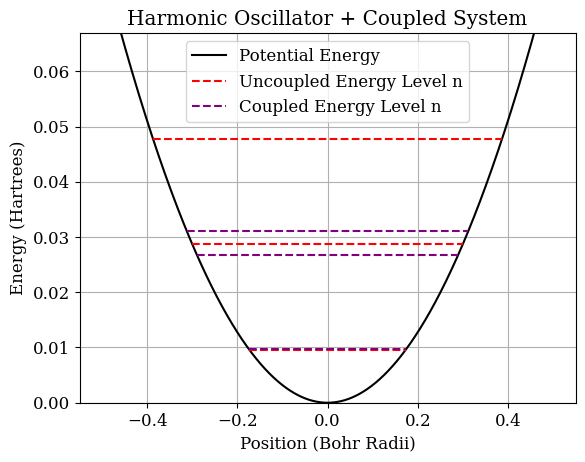

In [12]:

# Replot the potential
plt.plot(x, V, label='Potential Energy', color='black')

# Plot the energy eigenstates
n_max = 3  # number of eigenstates to plot
for n in range(n_max):
    E_n = energy(omega_au, n)
    pol_En = vals_pda[n]
    x_min, x_max = turning_points(omega_au, mu_au, E_n)
    pol_x_min, pol_x_max = turning_points(omega_au, mu_au, pol_En)
    plt.hlines(E_n, x_min, x_max, color='red', linestyle='--', label=f'Uncoupled Energy Level n' if n == 0 else None)
    plt.hlines(pol_En, pol_x_min, pol_x_max, color='purple', linestyle='--', label=f'Coupled Energy Level n' if n == 0 else None)

# Add labels and legend
plt.title('Harmonic Oscillator + Coupled System')
plt.xlabel('Position (Bohr Radii)')
plt.ylabel('Energy (Hartrees)')
plt.ylim(0, energy(omega_au, n_max))
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Printing matrices
It can be instructive to inspect the forms of each submatrix for the p dot A and Pauli-Fierz Hamiltonian.  The code block below repeats the builds for these matrices in a minimal basis for the matter and photon subsystems and prints each matrix with a heading.

In [13]:
# define dimensions of each subspace
photon_dim = 2 # can make this as small as 2 or as large as you dare... 100 is pretty large and will be slow
matter_dim = 2 # can make this as small as 2 or as large as you dare... 100 is pretty large and will be slow

# compute identity matrix on the matter subspace
I_matter = np.eye(matter_dim)

# compute identity matrix on the photon subspace
I_photon = np.eye(photon_dim)



# set k to be the force constant of HF in atomic units from the top of this notebook
k_val = k_au

# set mu to be the reduced mass of HF in atomic units from the top of this notebook
mu_val = mu_au

# set z to be the charge of HF in atomic units from the top of this notebook
z_val = z_au

# set the photon frequency to be equal to the fundamental frequency of HF
omega_p_val = np.sqrt( k_au / mu_au)

# assign a magnitude of the vector potential
A0_val = 2.0

# compute matter Hamiltonian in the matter basis
H_matter = compute_matter_energy_matrix(matter_dim, k_val, mu_val)

print("Bare matter Hamiltonian in the matter basis")
print(H_matter)

# compute matter Hamiltonian in the tensor product basis
H_matter_tp = np.kron(H_matter, I_photon)

print("Matter Hamiltonian in the tensor product basis")
print(H_matter_tp)

# compute photon Hamiltonian in the photon basis
H_photon = compute_cavity_energy_matrix(photon_dim, omega_cav)

print("Bare photon Hamiltonian in the photon basis")
print(H_photon)

# compute photon Hamiltonian in the tensor product basis
H_photon_tp = np.kron(I_matter, H_photon)

print("Photon Hamiltonian in the tensor product basis")
print(H_photon_tp)

# compute diamagnetic Hamiltonian in the photon basis
H_diamag = compute_diamagnetic_matrix_p_dot_A(photon_dim, z_val, A0_val, mu_val)

print("Diamagnetic Hamiltonian in the photon basis")
print(H_diamag)

# compute diamagnetic Hamiltonian in the tensor product basis
H_diamag_tp = np.kron(I_matter, H_diamag)

print("Diamagnetic Hamiltonian in the tensor product basis")
print(H_diamag_tp)

# compute the interaction Hamiltonian for p dot A
H_interaction_pda = compute_interaction_matrix_p_dot_A(matter_dim, photon_dim, mu_val, k_val, z_val, A0_val)

print("p dot A Interaction Hamiltonian in the tensor product basis")
print(H_interaction_pda)

# compute the total p dot A Hamiltonian in the tensor product basis
H_pda_tp = H_matter_tp + H_photon_tp + H_diamag_tp + H_interaction_pda

print("Total p dot A Hamiltonian in the tensor product basis")
print(H_pda_tp)


# compute the interaction Hamiltonian for PF
H_interaction_PF = compute_interaction_matrix_PF(matter_dim, photon_dim, omega_cav, mu_val, k_val, z_val, A0_val)

print("PF Interaction Hamiltonian in the tensor product basis")
print(H_interaction_PF)

# compute the dipole self energy for PF in the matter basis
H_dipole_self_energy_PF = compute_dipole_self_energy_PF(matter_dim, omega_cav, mu_val, k_val, z_val, A0_val)

print("Dipole self energy in the matter basis")
print(H_dipole_self_energy_PF)

# compute the dipole self energy for PF in the tensor product basis
H_dipole_self_energy_PF_tp = np.kron(H_dipole_self_energy_PF, I_photon)

print("Dipole self energy in the tensor product basis")
print(H_dipole_self_energy_PF_tp)

# compute the total Pauli-Fierz Hamiltonian
H_PF_tp = H_matter_tp + H_photon_tp + H_dipole_self_energy_PF_tp + H_interaction_PF

print("Total Pauli-Fierz Hamiltonian in the tensor product basis")
print(H_PF_tp)



Bare matter Hamiltonian in the matter basis
[[0.00955871 0.        ]
 [0.         0.02867612]]
Matter Hamiltonian in the tensor product basis
[[0.00955871 0.         0.         0.        ]
 [0.         0.00955871 0.         0.        ]
 [0.         0.         0.02867612 0.        ]
 [0.         0.         0.         0.02867612]]
Bare photon Hamiltonian in the photon basis
[[0.         0.        ]
 [0.         0.01911741]]
Photon Hamiltonian in the tensor product basis
[[0.         0.         0.         0.        ]
 [0.         0.01911741 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.01911741]]
Diamagnetic Hamiltonian in the photon basis
[[0.00025191 0.        ]
 [0.         0.00025191]]
Diamagnetic Hamiltonian in the tensor product basis
[[0.00025191 0.         0.         0.        ]
 [0.         0.00025191 0.         0.        ]
 [0.         0.         0.00025191 0.        ]
 [0.         0.         0.         0.00025191]]
p 

# Extensions to Anharmonic Oscillators
The Harmonic approximation neglects important features of the vibrational structure of molecules.  In particular, the Harmonic approximation does not permit dissociation of chemical bonds, does not adequately capture the fact that higher vibrational states are associated with average and most probable bond lengths that are stretched from equilibrium, does predict distinct vibrational transition energies seen in hot bands, and does not predict that overtone transitions can be spectroscopically excited.  

While beyond the scope of this primer, we wish to point out that the code above can be adapted to model potentials that capture anhoarmonic effects and that can recover the features described above.  There are a couple of trade offs that we wish to point out if one develops these models for general anharmonic oscillator potential.  The first trade off is that the simple rules of the ladder operators that enabled simple construction of the bare matter Hamiltonian, the dipole self energy, and the coupling matrices will no longer be suitable for anharmonic oscillators, and so one will have to adapt the construction of these operators accordingly.  The second tradeoff is that the eigenspectra of the p dot A and Pauli-Fierz Hamiltonians will typically not agree with each other at the same level of basis truncation.  They will converge to the same spectra in the complete basis limit, but depending on how strong the coupling is (i.e. the magnitude of ${\bf A}_0$, agreement between the two spectra may require a very large number of basis states for the matter and photonic subsystems.

We direct the interested reader to python code treating the p dot A, d dot E, and Pauli-Fierz Hamiltonians using the Morse potential for the vibrational structure [here](https://github.com/FoleyLab/ACS_Digital_Primer/blob/main/morse.py) with an associated notebook implementing this approach [here](https://github.com/FoleyLab/ACS_Digital_Primer/blob/main/Morse_fundamental.ipynb)

# Modeling Electronic Strong Coupling
While we have focused specifically on vibrational strong coupling in this notebook and in Chapter 2 of this primer, the formalism presented can also be applied to electronic strong coupling.  We direct the interested reader to an example where the magnesium hydride cation is coupled through an electronic transition to a cavity mode at ultraviolet frequencies [here](https://github.com/FoleyLab/MolSSI-MAPOL-Charlotte-CMS/blob/main/polariton_project/polariton_data/MgH_polaritonic_for_solutions.ipynb).  Just as in the Morse oscillator case, one will sacrifice simple analytical terms for the bilinear coupling and dipole self energy terms, but further, one will sacrifice analytical expressions even for the matter energy eigenstates.  In the linked notebook, we obtain energies and transition dipole moments from the time-dependent density functional theory formalism for the magnesium hydride subsystem, and use those quantities to parameterize our coupled model.  We also note that in this notebook, we effectively implement the Jaynes-Cummings model, which neglects the dipole self energy (and certain bilinear coupling elements known as the counter-rotating terms).  We encourage the interested reader to work through this example, and consider adding dipole self energy and counter rotating terms to evaluate their impact for different coupling strengths!